# ERM Decision Boundaries

Quick demo of how to draw decision boundaries for ERM with two classes: $C=2$.

Imports for this notebook:

In [1]:
import matplotlib.pyplot as plt # For general plotting

import numpy as np

from scipy.stats import multivariate_normal # MVN not univariate

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title

Consider following setting:

\begin{equation*}
    \mathbf{\mu}_0=\begin{bmatrix} -4\\0 \end{bmatrix} ~~~
    \mathbf{\Sigma}_0=\frac{1}{13}\begin{bmatrix}95 & -2 \\-2 & 3 \end{bmatrix}, ~~~
    \mathbf{\mu}_1=\begin{bmatrix} 4\\0 \end{bmatrix} ~~~
    \mathbf{\Sigma}_1=\frac{1}{3}\begin{bmatrix}5 & 1 \\1 & 4 \end{bmatrix}, ~~~
\end{equation*}

With priors $P(Y=0)=0.6$ and $P(Y=1)=0.4$

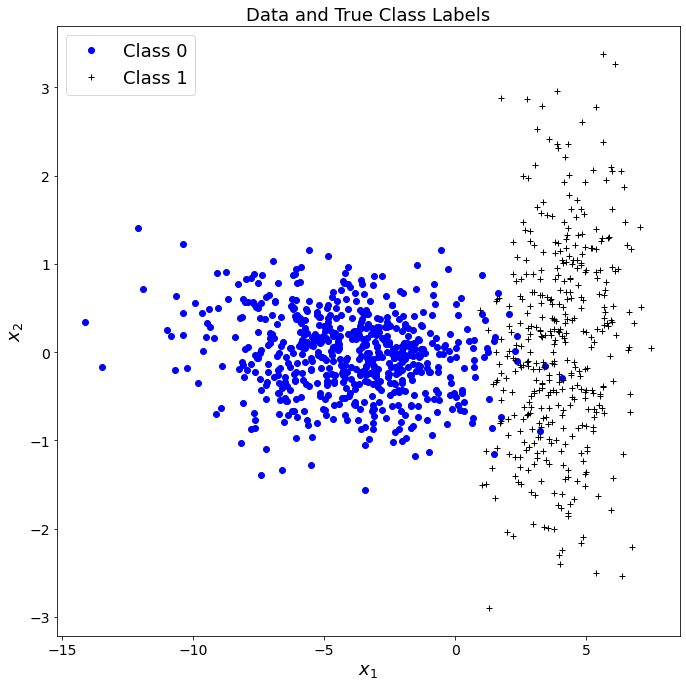

In [2]:
# Number of samples to draw from each distribution
N = 1000

mu = np.array([[-4, 0],
               [4, 0]])  # Gaussian distributions means
Sigma = np.array([[[95, -2],
                   [-2, 3]],
                  [[5, 1],
                   [1, 4]]])  # Gaussian distributions covariance matrices
Sigma = np.array((Sigma[0]/13, Sigma[1]/3))

# Determine dimensionality from PDF parameters
n = mu.shape[1]

# Class priors
priors = np.array([0.6, 0.4])  
C = len(priors)

# Decide randomly which samples will come from each component
labels = np.random.rand(N) >= priors[0]
L = np.array(range(C))
Nl = np.array([sum(labels == l) for l in L])

# Draw samples from each class pdf
X = np.zeros((N, n))
X[labels == 0, :] =  multivariate_normal.rvs(mu[0], Sigma[0], Nl[0])
X[labels == 1, :] =  multivariate_normal.rvs(mu[1], Sigma[1], Nl[1])


# Plot the original data and their true labels
fig = plt.figure(figsize=(10, 10))
plt.plot(X[labels==0, 0], X[labels==0, 1], 'bo', label="Class 0")
plt.plot(X[labels==1, 0], X[labels==1, 1], 'k+', label="Class 1")

plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Data and True Class Labels")
plt.tight_layout()
plt.show()

Plot a visualization of the data as a 2-dimensional scatter plot, with true labels and decision labels indicated using two separate visulization cues, such as marker shape and marker color, and comment on probability of error:

Smallest P(error) for ERM = 0.018


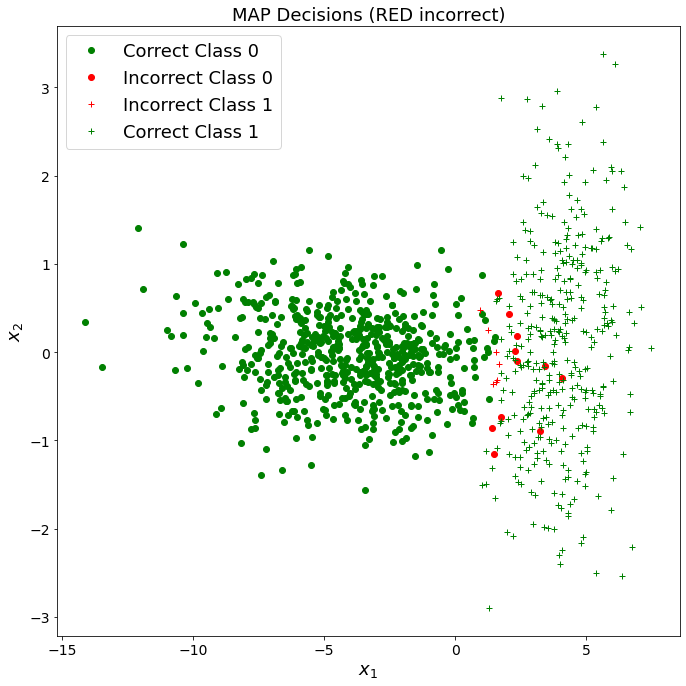

In [3]:
# Expected Risk Minimization Classifier (using true model parameters)
class_conditional_likelihoods = np.array([multivariate_normal.pdf(X, mu[l], Sigma[l]) for l in L])
# Discriminant score is LHS of likelihood-ratio test (LRT) 
discriminant_score_erm = np.log(class_conditional_likelihoods[1]) - np.log(class_conditional_likelihoods[0])

# Gamma threshold for MAP decision rule (same gamma on priors only; 0-1 loss simplification)
gamma_map = priors[0]/priors[1]
decisions_map = discriminant_score_erm >= np.log(gamma_map)

# Get indices and probability estimates of the four decision scenarios:
# (true negative, false positive, false negative, true positive)

# True Negative Probability
ind_00_map = np.argwhere((decisions_map==0) & (labels==0))
p_00_map = len(ind_00_map) / Nl[0]
# False Positive Probability
ind_10_map = np.argwhere((decisions_map==1) & (labels==0))
p_10_map = len(ind_10_map) / Nl[0]
# False Negative Probability
ind_01_map = np.argwhere((decisions_map==0) & (labels==1))
p_01_map = len(ind_01_map) / Nl[1]
# True Positive Probability
ind_11_map = np.argwhere((decisions_map==1) & (labels==1))
p_11_map = len(ind_11_map) / Nl[1]

# Probability of error for MAP classifier, empirically estimated
prob_error_erm = np.array((p_10_map, p_01_map)).dot(Nl.T / N)

# Display MAP decisions
fig_disc_grid, ax_disc = plt.subplots(figsize=(10,10));

# class 0 circle, class 1 +, correct green, incorrect red
ax_disc.plot(X[ind_00_map, 0], X[ind_00_map, 1], 'og', label="Correct Class 0")
ax_disc.plot(X[ind_10_map, 0], X[ind_10_map, 1], 'or', label="Incorrect Class 0")
ax_disc.plot(X[ind_01_map, 0], X[ind_01_map, 1], '+r', label="Incorrect Class 1")
ax_disc.plot(X[ind_11_map, 0], X[ind_11_map, 1], '+g', label="Correct Class 1")

ax_disc.legend()
ax_disc.set_xlabel(r"$x_1$")
ax_disc.set_ylabel(r"$x_2$")
ax_disc.set_title("MAP Decisions (RED incorrect)")
fig_disc_grid.tight_layout()

print("Smallest P(error) for ERM = {}".format(prob_error_erm))
fig_disc_grid;

Draw decision boundaries for when LHS and RHS of likelihood-ratio test are equal:

\begin{equation*}
ln~p(\mathbf{x};\mathbf{\mu}_1,\mathbf{\Lambda}_1) - ln~p(\mathbf{x};\mathbf{\mu}_0,\mathbf{\Lambda}_0) \begin{matrix} \text{Decide 1} \\ ~~~~>~~~~ \\ ~~~~<~~~~ \\ \text{Decide 0} \end{matrix} ln~\gamma
\end{equation*}

Or alternatively:

\begin{equation*}
ln~p(\mathbf{x};\mathbf{\mu}_1,\mathbf{\Lambda}_1) - ln~p(\mathbf{x};\mathbf{\mu}_0,\mathbf{\Lambda}_0) - ln~\gamma = 0
\end{equation*}

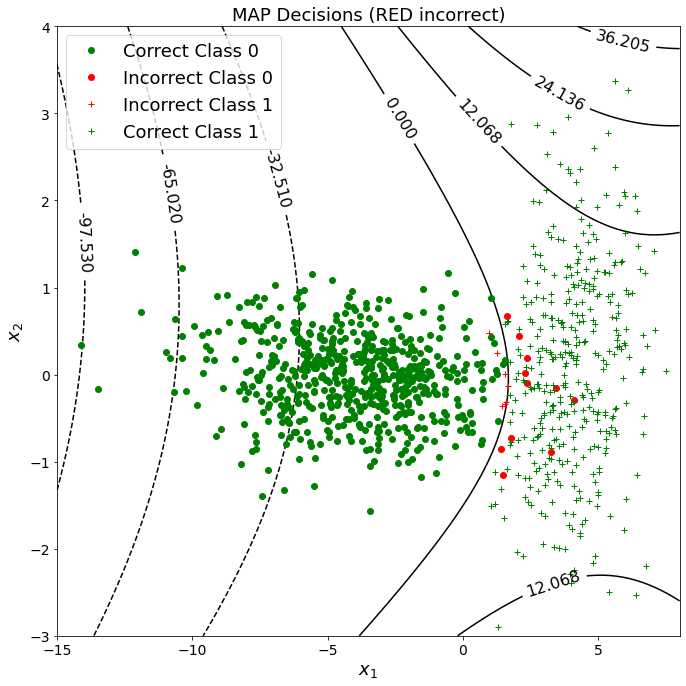

In [4]:
horizontal_grid = np.linspace(np.floor(np.min(X[:,0])), np.ceil(np.max(X[:,0])), 100)
vertical_grid = np.linspace(np.floor(np.min(X[:,1])), np.ceil(np.max(X[:,1])), 100)

# Generate a grid of scores that spans the full range of data 
[h, v] = np.meshgrid(horizontal_grid, vertical_grid)
# Flattening to feed vectorized matrix in pdf evaluation
gridxy = np.array([h.reshape(-1), v.reshape(-1)])
likelihood_grid_vals = np.array([multivariate_normal.pdf(gridxy.T, mu[l], Sigma[l]) for l in L])
# Where a score of 0 indicates decision boundary level
discriminant_score_grid_vals = np.log(likelihood_grid_vals[1]) - np.log(likelihood_grid_vals[0]) - np.log(gamma_map)

# Contour plot of decision boundaries
discriminant_score_grid_vals = np.array(discriminant_score_grid_vals).reshape(100, 100)
equal_levels = np.array((0.3, 0.6, 0.9))
min_DSGV = np.min(discriminant_score_grid_vals) * equal_levels[::-1]
max_DSGV = np.max(discriminant_score_grid_vals) * equal_levels
contour_levels = min_DSGV.tolist() + [0] + max_DSGV.tolist()
cs = ax_disc.contour(horizontal_grid, vertical_grid, discriminant_score_grid_vals.tolist(), contour_levels, colors='k')
ax_disc.clabel(cs, fontsize=16, inline=1)

fig_disc_grid